## Fungi Image Classification

In [302]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add, MaxPool2D
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, AdamW

print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

project_path = 'Defungi_S'
project_seed = 42
#project_image_size = (32,32)
project_image_size = (128,128)
#project_image_size = (500,500)
project_filter_size = 256
project_batch_size = 32
# project_batch_size = 128

Tensorflow Version: 2.14.0
Keras Version: 2.14.0


### Organizing the Data as a csv-file

In [293]:
# Load data from the directory using Pandas
# image_data = 'Defungi'

files = [i for i in glob.glob(project_path + "//*//*")]
np.random.shuffle(files)

# Taking the 2 symbols between the string 'Defungi\' and the file-name
labels = [os.path.dirname(i).split("/")[-1][-2:] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe.to_csv(project_path + '\Defungi.csv')
dataframe

,Image,Label
0,Defungi_S\H5\H5_3a_4.jpg,H5
1,Defungi_S\H3\H3_3a_8.jpg,H3
2,Defungi_S\H2\H2_1a_2.jpg,H2
3,Defungi_S\H6\H6_2a_2.jpg,H6
4,Defungi_S\H3\H3_3a_5.jpg,H3
...,...,...
395,Defungi_S\H5\H5_6a_1.jpg,H5
396,Defungi_S\H2\H2_1a_12.jpg,H2
397,Defungi_S\H2\H2_3a_1.jpg,H2
398,Defungi_S\H6\H6_2c_8.jpg,H6


### Exploring the Data

In [294]:
# Load training and testing data from the xray_data dataset using Pandas
Defungi_data = pd.read_csv(project_path + '\Defungi.csv')
Defungi_data.info()
print(Defungi_data.head(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  400 non-null    int64 
 1   Image       400 non-null    object
 2   Label       400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB
   Unnamed: 0                     Image Label
0           0  Defungi_S\H5\H5_3a_4.jpg    H5
1           1  Defungi_S\H3\H3_3a_8.jpg    H3
2           2  Defungi_S\H2\H2_1a_2.jpg    H2
3           3  Defungi_S\H6\H6_2a_2.jpg    H6


In [4]:
Defungi_data.describe()

,Unnamed: 0
count,400.000000
mean,199.500000
std,115.614301
min,0.000000
25%,99.750000
50%,199.500000
75%,299.250000
max,399.000000


### Uploading the Images from the Directory

In [295]:
import pathlib

data_dir = pathlib.Path(project_path)

data_train, data_val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    subset = 'both',
    labels = 'inferred',
#    label_mode = 'int',
    color_mode = 'rgb',
    image_size = project_image_size,
    batch_size = project_batch_size,
    seed = project_seed,
    validation_split = 0.2)

for x, y in data_val.take(4):
    print(x.shape, y)


Found 400 files belonging to 5 classes.
Using 320 files for training.
Using 80 files for validation.
(32, 128, 128, 3) tf.Tensor([2 3 4 3 4 4 3 3 2 2 0 2 2 3 3 1 0 0 0 1 2 0 3 1 4 0 4 3 3 0 3 1], shape=(32,), dtype=int32)
(32, 128, 128, 3) tf.Tensor([3 2 4 4 1 3 4 3 3 0 0 2 2 4 2 2 0 0 4 2 3 0 3 2 3 2 3 4 3 3 1 1], shape=(32,), dtype=int32)
(16, 128, 128, 3) tf.Tensor([1 4 1 4 1 4 2 1 4 0 2 0 1 3 4 1], shape=(16,), dtype=int32)


### Displaying the Images

32


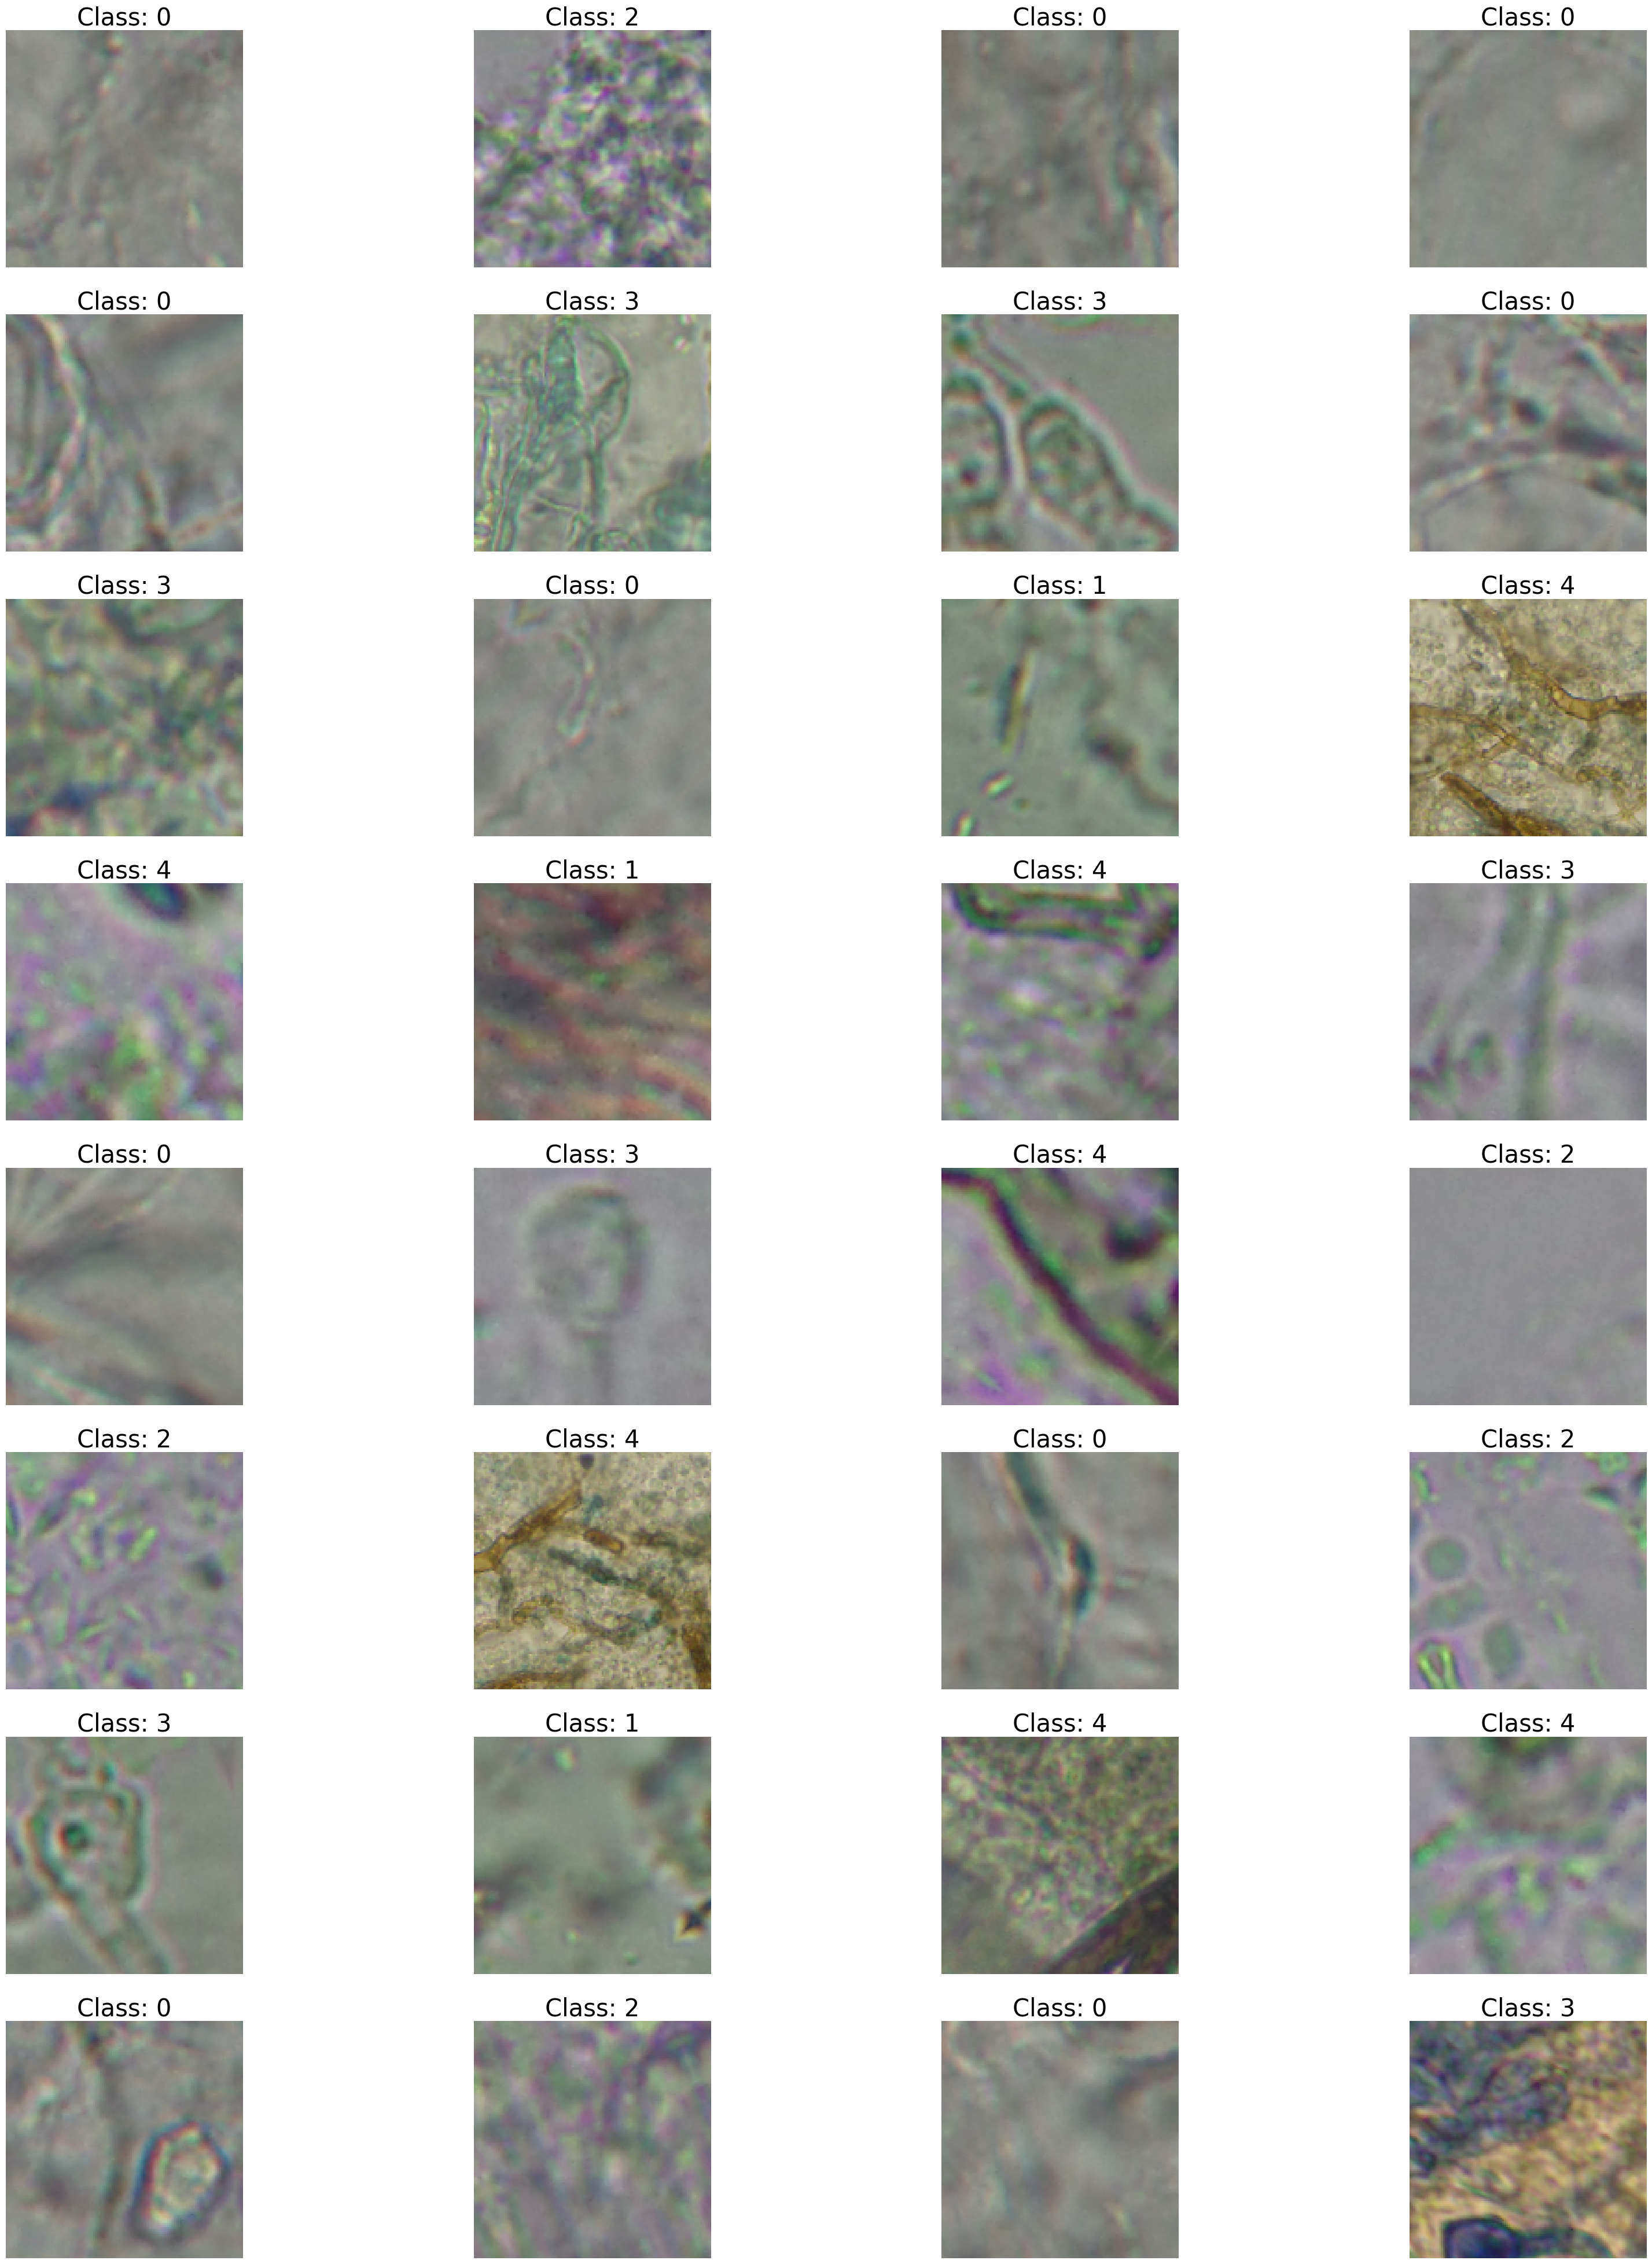

In [318]:
# Display the images
data_iterator = data_train.as_numpy_iterator()
images, labels = data_iterator.next()
print(len(images))
#plt.figure(figsize = (12, 8))
plt.figure(figsize = (40,50))
for i in range(len(images)):
    plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))
#    plt.title(f'Class: {np.argmax(labels[i])}')
    plt.title(f'Class: {labels[i]}', fontsize = 30) 
    plt.axis('off')

plt.show()

### Checking the Number of Data in Each Class

Label
H5    80
H3    80
H2    80
H6    80
H1    80
Name: count, dtype: int64


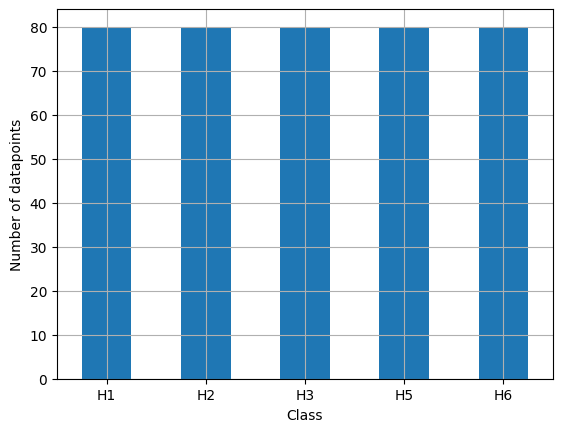

In [297]:
Cat = Defungi_data["Label"].value_counts()
print(Cat)
Defungi_data["Label"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Class")
plt.ylabel("Number of datapoints")
plt.show()

### Data Augmentation

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(32, 32, 32, 3) tf.Tensor([1 1 0 0 3 4 2 2 4 2 3 3 1 2 1 0 2 0 2 3 0 1 0 0 2 3 3 1 1 2 2 0], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([1 1 2 4 4 3 3 1 1 1 0 0 0 2 4 4 3 0 1 3 2 0 0 3 4 0 3 0 4 4 3 4], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([3 3 4 4 3 2 4 1 0 1 1 1 2 4 4 3 1 2 1 1 3 1 1 0 4 2 2 3 1 3 0 4], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([4 0 1 3 3 4 3 1 3 2 3 0 0 0 2 1 2 1 1 0 2 4 2 4 3 4 2 1 4 4 0 4], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([2 4 4 1 4 4 1 4 2 1 0 4 1 3 2 2 2 0 2 4 2 1 2 3 3 3 2 0 1 4 2 0], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([1 0 3 0 0 4 1 1 3 4 1 2 0 4 0 3 1 2 1 3 1 0 4 2 0 0 2 1 0 2 2 4], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([3 2 0 1 1 3 2 2 1 2 4 3 2 3 3 4 0 3 4 1 3 2 1 0 1 4 1 3 4 1 2 2], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([3 2 0 1 4 2 0 3 4 0

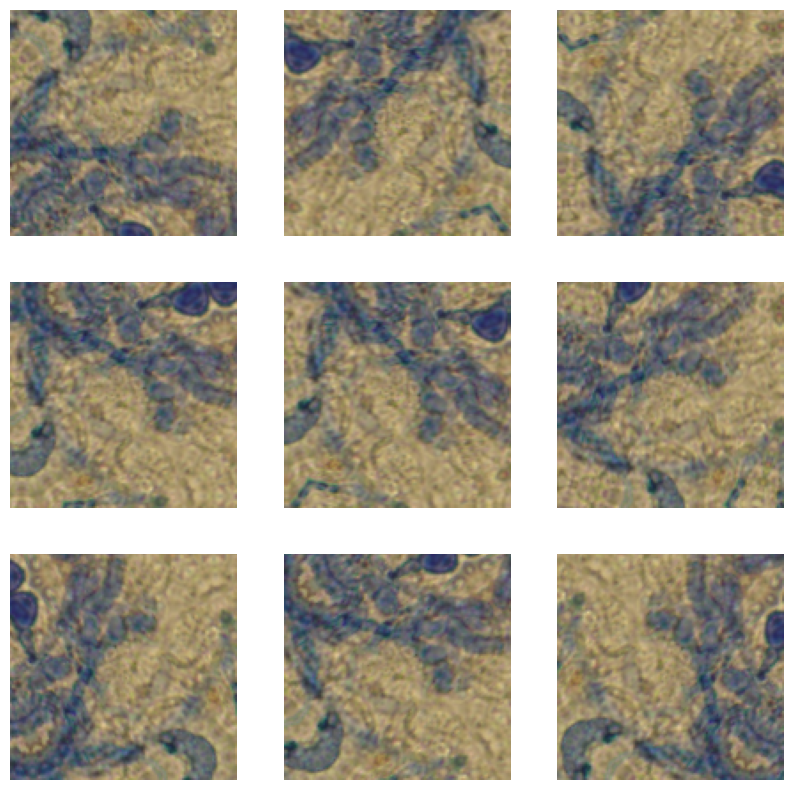

In [298]:
# Data Augmentation of the training images

data_augmentation = keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(factor = (-0.5, 0.5)),
    ])

data_train = data_train.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
data_train = data_train.prefetch(tf.data.AUTOTUNE)
data_val = data_val.prefetch(tf.data.AUTOTUNE)

print(train_ds.element_spec)
for x, y in train_ds.take(1000):
    print(x.shape, y)

plt.figure(figsize=(10, 10))
for images, _ in data_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Model from https://keras.io/examples/vision/image_classification_from_scratch/
### Hands-On-Machine Learning

In [258]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
def model_fungi_start(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
    # Rescaling reads a directory of images on disk
    x = tf.keras.layers.Rescaling(1/255.0)(inputs)

    # Conv2D is a class that spatial convolution over images
    # filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
    # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
    # strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    # padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
    
    # in https://www.kaggle.com/code/banddaniel/fungus-detect-w-10cv-custom-convmixer-f1-0-85/notebook
    # filter = 256
    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 5, strides = 2, padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    size = 256
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_start(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = project_filter_size)
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "model_66"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_117 (InputLayer)      [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_104 (Rescaling)   (None, 32, 32, 3)            0         ['input_117[0][0]']           
                                                                                                  
 conv2d_340 (Conv2D)         (None, 16, 16, 256)          19456     ['rescaling_104[0][0]']       
                                                                                                  
 batch_normalization_603 (B  (None, 16, 16, 256)          1024      ['conv2d_340[0][0]']          
 atchNormalization)                                                                        

In [299]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
def model_fungi_book(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
    # Rescaling reads a directory of images on disk
    x = tf.keras.layers.Rescaling(1/255.0)(inputs)

    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 7, strides = 2, padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)

    prev_filters = 64
    residual = x  # Set aside residual
        
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        if filters == prev_filters:
            strides = 1
        else:
            strides = 2
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(residual)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if filters != prev_filters:
            residual = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 1, strides = 4)(residual)
            
        x = tf.keras.layers.add([x, residual])  # Add back residual
        residual = tf.keras.layers.Activation("relu")(x)
        prev_filters = filters
            
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "model_76"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_140 (InputLayer)      [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_127 (Rescaling)   (None, 128, 128, 3)          0         ['input_140[0][0]']           
                                                                                                  
 conv2d_410 (Conv2D)         (None, 64, 64, 64)           9472      ['rescaling_127[0][0]']       
                                                                                                  
 batch_normalization_898 (B  (None, 64, 64, 64)           256       ['conv2d_410[0][0]']          
 atchNormalization)                                                                        

In [243]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
def model_fungi_conv_mixer(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1/255.0)(x)

    # Conv2D is a class that spatial convolution over images
    # filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
    # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
    # strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    # padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
    # in https://www.kaggle.com/code/banddaniel/fungus-detect-w-10cv-custom-convmixer-f1-0-85/notebook
    # filter = 256
    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 2, strides = 2, padding = "same")(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    vector_of_ones = np.ones(3, dtype = int)
    print(vector_of_ones)
    kernel_size = 5
    for size in 256 * vector_of_ones:
        x = tf.keras.layers.DepthwiseConv2D(kernel_size = kernel_size, strides = 2, padding = 'same')(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
#        x = tf.keras.layers.Add(inputs)
#        x = tf.keras.layers.Add()([x, inputs])
        x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 1)(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    X = tf.keras.layers.GlobalAveragePooling2D()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation = activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = project_filter_size)
model.summary()

[1 1]
Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_107 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 sequential_20 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 rescaling_93 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_322 (Conv2D)         (None, 16, 16, 256)       3328      
                                                                 
 activation_578 (Activation  (None, 16, 16, 256)       0         
 )                                                               
                                                                 
 batch_normalization_578 (B  (None, 16, 16, 256)       1024      
 atchNormalization)                                 

In [301]:
# training method "sgd" means that the model will be trained
# using stochastic gradient descent
# learning_rate is 0.001 (defaults learning rate is 0.01)
learning_rate = 0.0001
sgd = SGD(learning_rate = learning_rate)
Adamar = Adam(learning_rate = learning_rate)
#Adamar = AdamW(learning_rate = learning_rate)
epochs = 10

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
#scaler = preprocessing.StandardScaler().fit(data_train)

model.compile(
    optimizer = Adamar,
    loss = "sparse_categorical_crossentropy",
    metrics=["accuracy"])

model.fit(
    data_train,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = data_val)

Epoch 1/10
10/10 [==============================] - 19s 773ms/step - loss: 0.9067 - accuracy: 0.6094 - val_loss: 1.6062 - val_accuracy: 0.2000
Epoch 2/10
10/10 [==============================] - 6s 605ms/step - loss: 0.9049 - accuracy: 0.6187 - val_loss: 1.6055 - val_accuracy: 0.2000
Epoch 3/10
10/10 [==============================] - 6s 610ms/step - loss: 0.7945 - accuracy: 0.6750 - val_loss: 1.6047 - val_accuracy: 0.2625
Epoch 4/10
10/10 [==============================] - 6s 595ms/step - loss: 0.7329 - accuracy: 0.7188 - val_loss: 1.6037 - val_accuracy: 0.2625
Epoch 5/10
10/10 [==============================] - 6s 592ms/step - loss: 0.7683 - accuracy: 0.6687 - val_loss: 1.6034 - val_accuracy: 0.2625
Epoch 6/10
10/10 [==============================] - 6s 592ms/step - loss: 0.6307 - accuracy: 0.7656 - val_loss: 1.6028 - val_accuracy: 0.2625
Epoch 7/10
10/10 [==============================] - 7s 656ms/step - loss: 0.6648 - accuracy: 0.7125 - val_loss: 1.6026 - val_accuracy: 0.2625
Epoch